 ----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
<h1><center>
    
Practical exam on Computer Vision: Part I
    
(January, 18th, 2024)
</center></h1>   

Consider the following:

- You can answer in English, Spanish or Catalan. 

- Add title to figures and add sufficient comments on the code to understand it.

- Make sure to print and plot exactly what it is indicated. If a reference image is provided, your output is expected to be exactly the same unless instructed differently. 

- At the end of the exam, upload only your .ipynb file (no need to upload the images)
    
- Make sure your code can be ran by us without errors.

- Use packages and solutions that were covered in your class and tutorials. If you are unsure about using a particular package, you should seek clarification from your instructor to confirm whether it is allowed.

- Please note that partial credit will be given based on the correctness of the code and the logic demonstrated. If certain parts of your code or answers are accurate, even if the final output is not entirely correct, you may still receive points.

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte, img_as_float , transform
from skimage.exposure import histogram
from skimage.filters import gaussian, median
from skimage.transform import resize, rescale
from skimage.color import rgb2gray
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic, quickshift

## Exercise 1

### Greenland's flag

We're right in the middle of winter. The temperatures have dropped to their lowest, and many of us are daydreaming about the hotter days ahead. This seasonal shift draws a parallel to the symbolism embedded in Greenland's flag, where the red circle represents the warmth and hope for brighter days ahead.

**Ex.1** (3 points) Load the image `red_circle.png` from the folder `images` and print it's principal image features: type and shape. Use the image to compose the Greenland's flag, like in the image below.

**Hint**: Use a mask to extract the red circle from the image. Create a new white array with the shape of `red_circle.png` and use it, along with the previous image, to create the result. The color of the circle corresponding to the RGB standard is [255,0,0].

<img src="images/ejercicio1.png" width="515" height="350">

Tipo de dato de la imagen: uint8
Forma de la imagen (alto, ancho, canales): (350, 515, 4)
Convertida de RGBA a RGB.


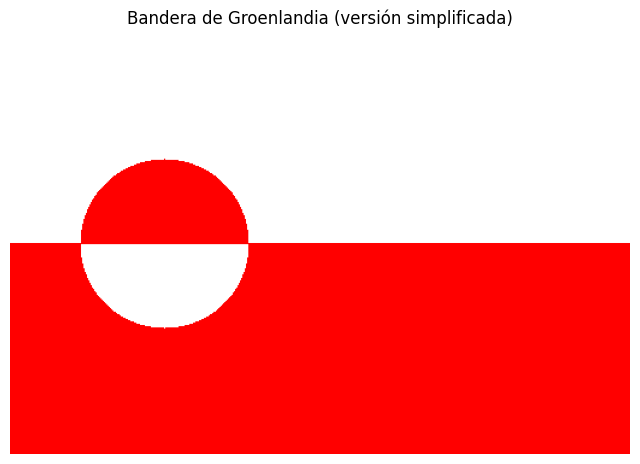

In [68]:
# Your solution
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color

# 1. Cargar la imagen con el círculo rojo
image_path = 'images/red_circle.png'
image = io.imread(image_path)

# 2. Mostrar características principales de la imagen
print("Tipo de dato de la imagen:", image.dtype)
print("Forma de la imagen (alto, ancho, canales):", image.shape)

# 3. Convertir de RGBA a RGB si es necesario
if image.ndim == 3 and image.shape[2] == 4:
    # Convertir RGBA a RGB
    image_rgb = color.rgba2rgb(image)
    # Convertir de float [0,1] a uint8 [0,255]
    image_rgb = (image_rgb * 255).astype(np.uint8)
    print("Convertida de RGBA a RGB.")
else:
    image_rgb = image.copy()
    print("Imagen ya está en formato RGB.")

# 4. Actualizar dimensiones después de la conversión
H, W, C = image_rgb.shape

# 5. Crear la bandera de Groenlandia como base:
flag = np.zeros_like(image_rgb, dtype=np.uint8)

# - Mitad superior: blanca
flag[:H//2, :] = [255, 255, 255]

# - Mitad inferior: roja
flag[H//2:, :] = [255, 0, 0]

# 6. Definir parámetros del círculo
# Tolerancia para capturar píxeles cercanos al rojo puro debido al anti-aliasing
tolerance = 10
red_color = np.array([255, 0, 0])

# Definir radio y centro desplazado
radius = int(min(H, W) * 0.2)  # 20% de la dimensión más pequeña
center_y = H // 2
center_x = W // 4  # Desplazado hacia la izquierda (25% del ancho)

# Crear malla de coordenadas
Y, X = np.ogrid[:H, :W]

# Calcular la distancia desde el centro desplazado
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

# Crear máscara del círculo
circle_mask = dist_from_center <= radius

# Dividir el círculo en mitades: superior blanca e inferior roja
half_circle = Y <= center_y

# Aplicar blanco a la mitad superior del círculo
flag[circle_mask & half_circle] = [255, 0, 0]  # Blanco

# Aplicar rojo a la mitad inferior del círculo
flag[circle_mask & ~half_circle] = [255, 255, 255]       # Rojo

# 7. Mostrar el resultado final
plt.figure(figsize=(8, 6))
plt.imshow(flag)
plt.axis('off')
plt.title("Bandera de Groenlandia (versión simplificada)")
plt.show()

# 8. (Opcional) Guardar la bandera compuesta
# io.imsave('images/greenland_flag.png', flag)
# print("Bandera de Groenlandia guardada como 'greenland_flag.png'.")

## Exercise 2

### Spring time

At the moment it is still winter in Barcelona. Let's help the change of seasons with an exercise.

**Ex 2.1** (2 points) Read the images `./images/barcelona_nieve.png` and `./images/barcelona_primavera.png` and obtain their low frequency and high frequency counterparts. Visualize them, along with their titles. Apply a low-pass filter using a sigma with value lower_sigma = 5 and a high-pass filter using a sigma with value high_sigma = 10. 

<img src="images/ejercicio21.png" width="515" height="350">

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.filters import gaussian
from skimage import img_as_float, img_as_ubyte

# Define sigma values
lower_sigma = 5
high_sigma = 10

# Function to apply low-pass filter
def apply_low_pass(image, sigma):
    return gaussian(image, sigma=sigma, channel_axis=2)

# Function to apply high-pass filter
def apply_high_pass(original, sigma):
    low_pass = gaussian(original, sigma=sigma, channel_axis=2)
    high_pass = original - low_pass
    # Tomar el valor absoluto para evitar valores negativos
    high_pass_abs = np.abs(high_pass)
    # Escalar los valores al rango [0, 1]
    high_pass_normalized = (high_pass_abs - high_pass_abs.min()) / (high_pass_abs.max() - high_pass_abs.min())
    return high_pass_normalized

# Load and preprocess images
def load_image(path):
    img = io.imread(path)
    if img.shape[-1] == 4:
        # Convert RGBA to RGB
        img = color.rgba2rgb(img)
        img = img_as_float(img)
    else:
        img = img_as_float(img)
    return img

# Paths to images
nieve_path = './images/barcelona_nieve.png'
primavera_path = './images/barcelona_primavera.jpg'

# Load images
nieve_img = load_image(nieve_path)
primavera_img = load_image(primavera_path)

# Apply filters to "barcelona_nieve.png"
nieve_low = apply_low_pass(nieve_img, lower_sigma)
nieve_high = apply_high_pass(nieve_img, high_sigma)

# Apply filters to "barcelona_primavera.png"
primavera_low = apply_low_pass(primavera_img, lower_sigma)
primavera_high = apply_high_pass(primavera_img, high_sigma)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Barcelona Nieve
axes[0, 0].imshow(nieve_img)
axes[0, 0].set_title('Barcelona Nieve - Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(nieve_low)
axes[0, 1].set_title(f'Low-Pass Filter (σ={lower_sigma})')
axes[0, 1].axis('off')

axes[0, 2].imshow(nieve_high)
axes[0, 2].set_title(f'High-Pass Filter (σ={high_sigma})')
axes[0, 2].axis('off')

# Barcelona Primavera
axes[1, 0].imshow(primavera_img)
axes[1, 0].set_title('Barcelona Primavera - Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(primavera_low)
axes[1, 1].set_title(f'Low-Pass Filter (σ={lower_sigma})')
axes[1, 1].axis('off')

axes[1, 2].imshow(primavera_high)
axes[1, 2].set_title(f'High-Pass Filter (σ={high_sigma})')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

**Ex 2.2** (2 points) Use the obtained images to create hybrid images like the ones below.

<img src="images/ejercicio22.png" width="515" height="350">

Dimensiones originales - Nieve: (872, 1550, 3), Primavera: (200, 300, 3)
Dimensiones después de redimensionar - Nieve: (872, 1550, 3), Primavera Redimensionada: (872, 1550, 3)


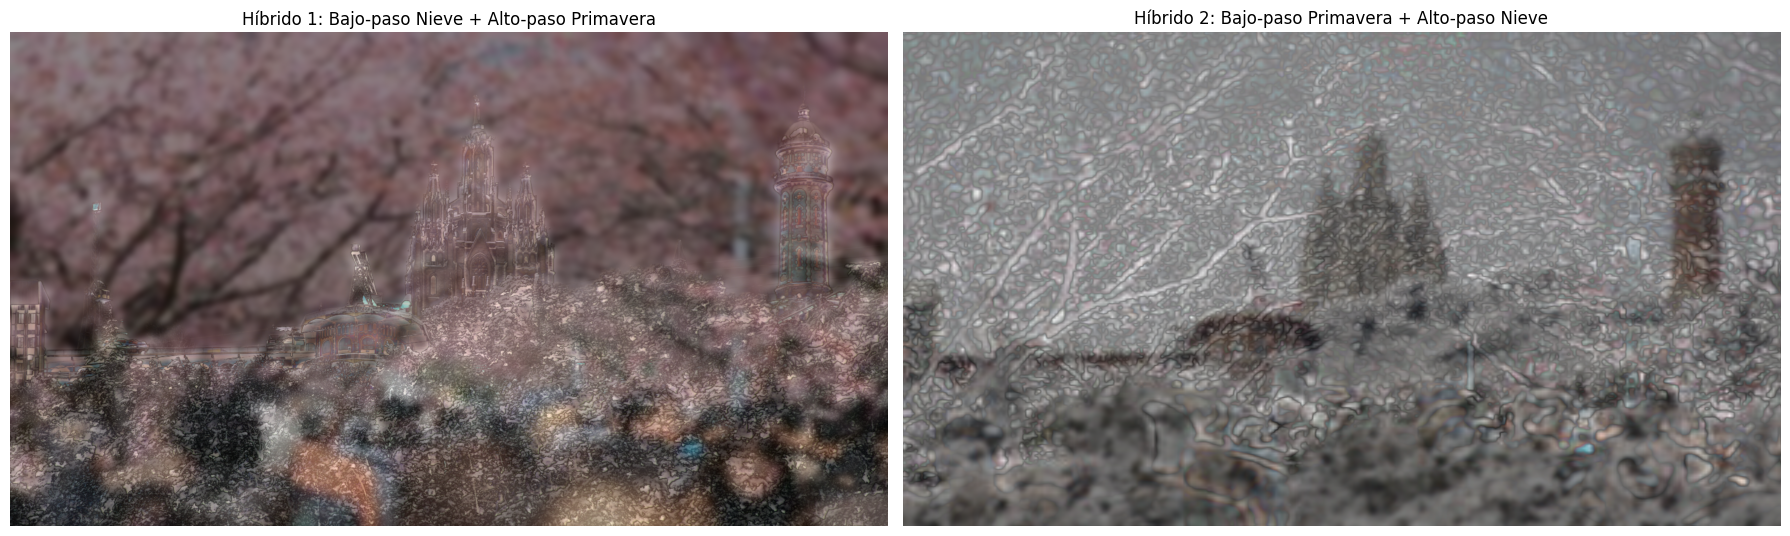

In [57]:
# Your solution
# Verificar dimensiones antes de redimensionar
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.filters import gaussian
from skimage import img_as_float
from skimage.transform import resize

# Definir valores de sigma
lower_sigma = 5
high_sigma = 10

# Función para aplicar filtro de bajo-paso
def apply_low_pass(image, sigma):
    return gaussian(image, sigma=sigma, channel_axis=2)

# Función para aplicar filtro de alto-paso
def apply_high_pass(original, sigma):
    low_pass = gaussian(original, sigma=sigma, channel_axis=2)
    high_pass = original - low_pass
    # Tomar el valor absoluto para evitar valores negativos
    high_pass_abs = np.abs(high_pass)
    # Escalar los valores al rango [0, 1]
    high_pass_normalized = (high_pass_abs - high_pass_abs.min()) / (high_pass_abs.max() - high_pass_abs.min())
    return high_pass_normalized

# Función para cargar y preprocesar imágenes
def load_image(path):
    img = io.imread(path)
    if img.ndim == 3 and img.shape[-1] == 4:
        # Convertir de RGBA a RGB
        img = color.rgba2rgb(img)
    img = img_as_float(img)
    return img

# Función para redimensionar una imagen a las dimensiones de otra
def resize_to_match(source, target):
    return resize(source, target.shape, anti_aliasing=True)

# Rutas a las imágenes
nieve_path = './images/barcelona_nieve.png'
primavera_path = './images/barcelona_primavera.jpg'

# Cargar imágenes
nieve_img = load_image(nieve_path)
primavera_img = load_image(primavera_path)

# Verificar dimensiones antes de redimensionar
print(f"Dimensiones originales - Nieve: {nieve_img.shape}, Primavera: {primavera_img.shape}")

# Redimensionar 'primavera_img' para que coincida con 'nieve_img'
primavera_img_resized = resize_to_match(primavera_img, nieve_img)

# Verificar dimensiones después de redimensionar
print(f"Dimensiones después de redimensionar - Nieve: {nieve_img.shape}, Primavera Redimensionada: {primavera_img_resized.shape}")

# Aplicar filtros a "barcelona_nieve.png"
nieve_low = apply_low_pass(nieve_img, lower_sigma)
nieve_high = apply_high_pass(nieve_img, high_sigma)

# Aplicar filtros a "barcelona_primavera_resized.png"
primavera_low = apply_low_pass(primavera_img_resized, lower_sigma)
primavera_high = apply_high_pass(primavera_img_resized, high_sigma)

# Crear imágenes híbridas
hybrid1 = nieve_high + primavera_low
hybrid2 = primavera_high + nieve_low

# Normalizar imágenes híbridas al rango [0, 1]
hybrid1 = hybrid1 / np.max(hybrid1)
hybrid2 = hybrid2 / np.max(hybrid2)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Imagen Híbrida 1: Bajo-paso Nieve + Alto-paso Primavera
axes[0].imshow(hybrid1)
axes[0].set_title('Híbrido 1: Bajo-paso Nieve + Alto-paso Primavera')
axes[0].axis('off')

# Imagen Híbrida 2: Bajo-paso Primavera + Alto-paso Nieve
axes[1].imshow(hybrid2)
axes[1].set_title('Híbrido 2: Bajo-paso Primavera + Alto-paso Nieve')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Exercise 3

### Polar ice melting

Now that we have successfully invoked spring in Barcelona, let's redirect our attention to Greenland, where the melting of the polar ice has been a persistent issue for decades. We will analyze the thaw using histograms and examine the paths left by the melting ice.

**Ex.3.1** (0.5 points) Read the images `before_glacier.png` together with the  image `after_glacier.png` from the folder `images`. Rescale the first image to match the shape of the second one. Show both images in one single figure, with their titles, using the `subplots` function.

<img src="images/ejercicio31.png" width="515" height="350">

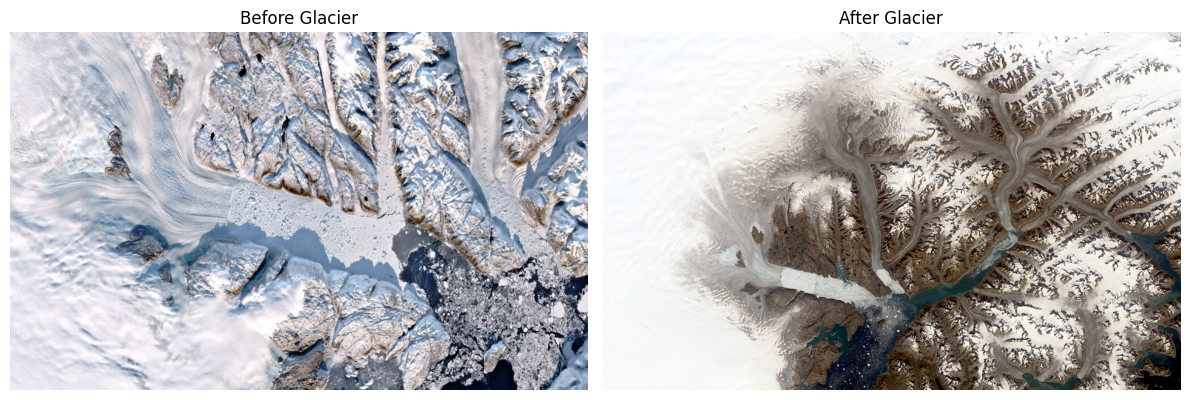

In [58]:
# Your solution
before_path = 'images/before_glacier.png'
after_path = 'images/after_glacier.png'

before_img = io.imread(before_path)
after_img = io.imread(after_path)

# Rescale 'before' image to match 'after' image's shape
before_rescaled = transform.resize(before_img, after_img.shape, anti_aliasing=True)

# Display both images using subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(before_rescaled)
axes[0].set_title('Before Glacier')
axes[0].axis('off')

axes[1].imshow(after_img)
axes[1].set_title('After Glacier')
axes[1].axis('off')

plt.tight_layout()
plt.show()

**Ex.3.2** (1 point) Visualize the histogram with 32 bins of the RGB images and grayscale images. Explain the difference between both histograms.

<img src="images/ejercicio32old.png" width="515" height="350">
<img src="images/ejercicio32new.png" width="515" height="350">

In [59]:
import matplotlib.pyplot as plt
from skimage import io, color

# Cargar imagen RGBA
rgba_img = io.imread('images/ejercicio32old.png')

# Convertir de RGBA a RGB si es necesario
if rgba_img.shape[2] == 4:
    rgb_img = color.rgba2rgb(rgba_img)
else:
    rgb_img = rgba_img

# Convertir la imagen RGB a escala de grises
gray_img = color.rgb2gray(rgb_img)

# Definir número de bins
bins = 32

# Plotear histogramas de los canales RGB
plt.figure(figsize=(10, 5))
plt.hist(rgb_img[:, :, 0].ravel(), bins=bins, color='red', alpha=0.5, label='Rojo')
plt.hist(rgb_img[:, :, 1].ravel(), bins=bins, color='green', alpha=0.5, label='Verde')
plt.hist(rgb_img[:, :, 2].ravel(), bins=bins, color='blue', alpha=0.5, label='Azul')

# Plotear histograma para la imagen en escala de grises
plt.hist(gray_img.ravel(), bins=bins, color='gray', alpha=0.5, label='Gris')

plt.title('Histogramas de RGB y Escala de Grises')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

**Ex.3.3** (1.5 points) Apply the Slic and Felzenswalb image segmentation methods to both images.

Use the following sets of parameters:
- Felzenszwalb: scale=300, sigma=2
- Slic: n_segments=100, start_label=1

<img src="images/ejercicio33.png" width="515" height="350">

In [60]:
# Your solution
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.segmentation import felzenszwalb, slic, mark_boundaries

# Cargar imágenes
before_path = 'images/before_glacier.png'
after_path = 'images/after_glacier.png'

before_img = io.imread(before_path)
after_img = io.imread(after_path)

# Convertir de RGBA a RGB si es necesario
def ensure_rgb(image):
    if image.ndim == 3 and image.shape[2] == 4:
        return color.rgba2rgb(image)
    return image

before_rgb = ensure_rgb(before_img)
after_rgb = ensure_rgb(after_img)

# Aplicar Felzenszwalb
felz_before = felzenszwalb(before_rgb, scale=300, sigma=2, min_size=50)
felz_after = felzenszwalb(after_rgb, scale=300, sigma=2, min_size=50)

# Aplicar SLIC
slic_before = slic(before_rgb, n_segments=100, start_label=1, compactness=10)
slic_after = slic(after_rgb, n_segments=100, start_label=1, compactness=10)

# Visualizar resultados
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Antes del Glaciar
axes[0, 0].imshow(before_rgb)
axes[0, 0].set_title('Antes del Glaciar - Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(mark_boundaries(before_rgb, felz_before,color=(1, 0, 0)))
axes[0, 1].set_title('Antes del Glaciar - Felzenszwalb')
axes[0, 1].axis('off')

axes[0, 2].imshow(mark_boundaries(before_rgb, slic_before,color=(1, 0, 0)))
axes[0, 2].set_title('Antes del Glaciar - SLIC')
axes[0, 2].axis('off')

# Después del Glaciar
axes[1, 0].imshow(after_rgb)
axes[1, 0].set_title('Después del Glaciar - Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(mark_boundaries(after_rgb, felz_after,color=(1, 0, 0)))
axes[1, 1].set_title('Después del Glaciar - Felzenszwalb')
axes[1, 1].axis('off')

axes[1, 2].imshow(mark_boundaries(after_rgb, slic_after,color=(1, 0, 0)))
axes[1, 2].set_title('Después del Glaciar - SLIC')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

Which method segments better?

In [61]:
# Your solution
 # Fezenswalb es mejor al ser una segmentación más detallada y precisa

How have the parameters affected the segmentation?

In [62]:
# Your solution

#elzenszwalb (scale=300, sigma=2):
''' 
Segmentos Más Grandes y Menos Detallados: El alto valor de scale combinado con un sigma moderado resulta en una segmentación que captura las estructuras más prominentes del glaciar, evitando la fragmentación excesiva.
Adherencia a Bordes Naturales: El método puede seguir mejor los bordes naturales y las transiciones suaves en la imagen, ofreciendo una representación más precisa de las características del glaciar.
SLIC (n_segments=100, start_label=1, compactness=10):

Segmentos Más Uniformes y Compactos: Con n_segments=100 y compactness=10, SLIC genera superpíxeles más uniformes en tamaño y bien compactos espacialmente, facilitando ciertos análisis posteriores.
Menor Adaptabilidad a Bordes Naturales: Aunque produce segmentos consistentes, puede no capturar con la misma precisión las transiciones suaves y las complejidades de los bordes naturales presentes en las imágenes de glaciares.'''

' \nSegmentos Más Grandes y Menos Detallados: El alto valor de scale combinado con un sigma moderado resulta en una segmentación que captura las estructuras más prominentes del glaciar, evitando la fragmentación excesiva.\nAdherencia a Bordes Naturales: El método puede seguir mejor los bordes naturales y las transiciones suaves en la imagen, ofreciendo una representación más precisa de las características del glaciar.\nSLIC (n_segments=100, start_label=1, compactness=10):\n\nSegmentos Más Uniformes y Compactos: Con n_segments=100 y compactness=10, SLIC genera superpíxeles más uniformes en tamaño y bien compactos espacialmente, facilitando ciertos análisis posteriores.\nMenor Adaptabilidad a Bordes Naturales: Aunque produce segmentos consistentes, puede no capturar con la misma precisión las transiciones suaves y las complejidades de los bordes naturales presentes en las imágenes de glaciares.'